In [2]:
# Bat Call Dataset Exploratory Data Analysis (EDA)
'''
This notebook analyzes the dataset in the folder:
**"Cleaned Bat Echolocation calls of South India"**  
Each of the 29 species folders may contain audio files (in .wav or .pkf formats) directly or in subfolders.

We will:
- Count total files and counts by extension.
- Compute per-species counts.
- Generate bar graphs, histograms, and scatter plots.
- Compare spectral features and spectrograms.
- Cluster spectral features using KMeans.
- Print a summary report of the dataset.
'''

'\nThis notebook analyzes the dataset in the folder:\n**"Cleaned Bat Echolocation calls of South India"**  \nEach of the 29 species folders may contain audio files (in .wav or .pkf formats) directly or in subfolders.\n\nWe will:\n- Count total files and counts by extension.\n- Compute per-species counts.\n- Generate bar graphs, histograms, and scatter plots.\n- Compare spectral features and spectrograms.\n- Cluster spectral features using KMeans.\n- Print a summary report of the dataset.\n'

In [5]:
import os
import glob
import pickle
import torchaudio
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import pandas as pd
import random
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Use a known seaborn style that exists:
print(plt.style.available)
plt.style.use("seaborn-v0_8-darkgrid")


['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [7]:
def get_all_audio_files(folder):
    """Recursively traverse folder to return all .wav and .pkf file paths."""
    audio_files = []
    for root, dirs, files in os.walk(folder):
        for file in files:
            if file.lower().endswith(('.wav', '.pkf')):
                full_path = os.path.join(root, file)
                audio_files.append(full_path)
    return audio_files

def count_files_by_extension(files_list):
    """Return dictionary with counts for each extension."""
    counts = {'.wav': 0, '.pkf': 0}
    for f in files_list:
        ext = os.path.splitext(f)[1].lower()
        if ext in counts:
            counts[ext] += 1
    return counts

def load_audio(filepath, sr=192000):
    """Load audio from .wav or .pkf file and resample from 48000 Hz to target sr."""
    ext = os.path.splitext(filepath)[1].lower()
    if ext == ".wav":
        try:
            waveform, _ = torchaudio.load(filepath)
            waveform = waveform.numpy()[0]  # Assume single-channel
        except Exception as e:
            print(f"Error loading WAV file {filepath}: {e}")
            return None
    elif ext == ".pkf":
        try:
            with open(filepath, "rb") as f:
                waveform = pickle.load(f)
            waveform = np.array(waveform, dtype=np.float32)
        except Exception as e:
            print(f"Pickle loading failed for {filepath}: {e}")
            try:
                with open(filepath, "rb") as f:
                    _ = f.read(20)  # Skip header bytes
                    raw_data = f.read()
                waveform = np.frombuffer(raw_data, dtype=np.float32)
            except Exception as e2:
                print(f"Fallback loading failed for {filepath}: {e2}")
                return None
    else:
        print(f"Unsupported file type: {filepath}")
        return None
    try:
        waveform = librosa.resample(waveform, orig_sr=48000, target_sr=sr)
    except Exception as e:
        print(f"Error during resampling {filepath}: {e}")
        return None
    return waveform

def waveform_to_logmel(waveform, sr=192000, n_mels=128, n_fft=2048, hop_length=512):
    try:
        S = librosa.feature.melspectrogram(y=waveform, sr=sr, n_fft=n_fft,
                                           hop_length=hop_length, n_mels=n_mels)
        log_S = librosa.power_to_db(S, ref=np.max)
    except Exception as e:
        print(f"Error generating spectrogram: {e}")
        return None
    return log_S

def compute_spectral_centroid(waveform, sr=192000):
    centroid = librosa.feature.spectral_centroid(y=waveform, sr=sr)
    return np.mean(centroid)

def compute_spectral_rolloff(waveform, sr=192000):
    rolloff = librosa.feature.spectral_rolloff(y=waveform, sr=sr)
    return np.mean(rolloff)


In [8]:
parent_folder = "Cleaned Bat Echolocation calls of South India"

all_files = get_all_audio_files(parent_folder)
total_files = len(all_files)
ext_counts = count_files_by_extension(all_files)

print(f"Total audio files in '{parent_folder}': {total_files}")
print("File counts by extension:", ext_counts)


Total audio files in 'Cleaned Bat Echolocation calls of South India': 5808
File counts by extension: {'.wav': 3067, '.pkf': 2741}


In [9]:
species_counts = {}
species_ext_counts = {}

# List immediate subfolders as species folders
species_folders = [os.path.join(parent_folder, d) for d in os.listdir(parent_folder)
                   if os.path.isdir(os.path.join(parent_folder, d))]

for species_path in species_folders:
    species_name = os.path.basename(species_path)
    files = get_all_audio_files(species_path)
    species_counts[species_name] = len(files)
    species_ext_counts[species_name] = count_files_by_extension(files)
    print(f"Species: {species_name}")
    print(f"  Total files: {len(files)}")
    print(f"  Extension counts: {species_ext_counts[species_name]}")

species_df = pd.DataFrame({
    "Species": list(species_counts.keys()),
    "Total Files": list(species_counts.values())
}).sort_values(by="Total Files", ascending=False)


Species: Chaerephon plicatus
  Total files: 12
  Extension counts: {'.wav': 12, '.pkf': 0}
Species: Hesperotenus tickelli
  Total files: 5
  Extension counts: {'.wav': 5, '.pkf': 0}
Species: Hipposideros ater
  Total files: 67
  Extension counts: {'.wav': 67, '.pkf': 0}
Species: Hipposideros fulvus
  Total files: 50
  Extension counts: {'.wav': 25, '.pkf': 25}
Species: Hipposideros hyphophyllus
  Total files: 33
  Extension counts: {'.wav': 33, '.pkf': 0}
Species: Hipposideros lankadiva
  Total files: 222
  Extension counts: {'.wav': 111, '.pkf': 111}
Species: Hipposideros pamona
  Total files: 207
  Extension counts: {'.wav': 115, '.pkf': 92}
Species: Hipposideros speoris
  Total files: 1166
  Extension counts: {'.wav': 647, '.pkf': 519}
Species: Lyroderma lyra (Megaderma lyra)
  Total files: 180
  Extension counts: {'.wav': 91, '.pkf': 89}
Species: Megaderma spasma
  Total files: 28
  Extension counts: {'.wav': 15, '.pkf': 13}
Species: Miniopterus philipsi
  Total files: 34
  Extensi

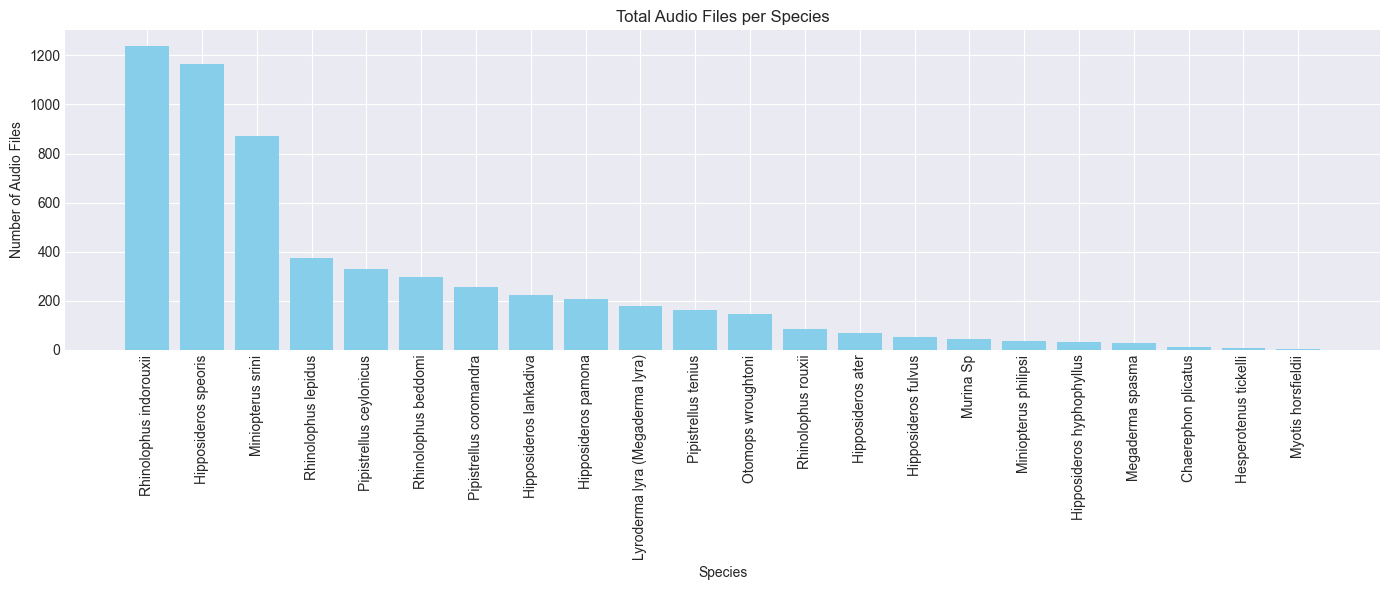

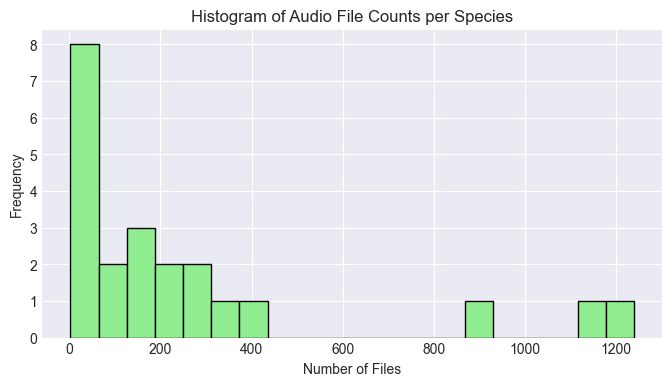

In [10]:
plt.figure(figsize=(14,6))
plt.bar(species_df["Species"], species_df["Total Files"], color='skyblue')
plt.xlabel("Species")
plt.ylabel("Number of Audio Files")
plt.title("Total Audio Files per Species")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
plt.hist(species_df["Total Files"], bins=20, color='lightgreen', edgecolor='black')
plt.xlabel("Number of Files")
plt.ylabel("Frequency")
plt.title("Histogram of Audio File Counts per Species")
plt.show()


In [11]:
sorted_species = sorted(species_counts.items(), key=lambda x: x[1], reverse=True)
top5 = sorted_species[:5]
least5 = sorted_species[-5:]

print("Top 5 most recorded species:")
for sp, cnt in top5:
    print(f"  {sp}: {cnt} files")

print("\nLeast 5 recorded species:")
for sp, cnt in least5:
    print(f"  {sp}: {cnt} files")


Top 5 most recorded species:
  Rhinolophus indorouxii: 1240 files
  Hipposideros speoris: 1166 files
  Miniopterus srini: 870 files
  Rhinolophus lepidus: 374 files
  Pipistrellus ceylonicus: 331 files

Least 5 recorded species:
  Hipposideros hyphophyllus: 33 files
  Megaderma spasma: 28 files
  Chaerephon plicatus: 12 files
  Hesperotenus tickelli: 5 files
  Myotis horsfieldii: 2 files



Spectral Feature Analysis for two random species:
Pickle loading failed for Cleaned Bat Echolocation calls of South India\Rhinolophus rouxii\Barapede-Feb 2020\BCIT___20200229_190338_1_20200229190348.pkf: invalid load key, 'k'.
Species: Rhinolophus rouxii
  Sample file: Cleaned Bat Echolocation calls of South India\Rhinolophus rouxii\Barapede-Feb 2020\BCIT___20200229_190338_1_20200229190348.pkf
  Mean Spectral Centroid: 14668.79 Hz
  Mean Spectral Rolloff: 21047.29 Hz


c:\Users\jambu\AppData\Local\Programs\Python\Python312\Lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


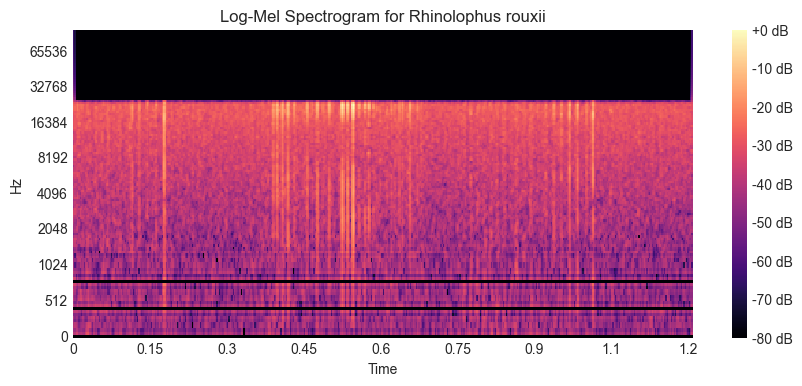

Species: Miniopterus srini
  Sample file: Cleaned Bat Echolocation calls of South India\Miniopterus srini\Castle Rock Ivoli-Apr-2023\20230420_193357_1_20230420193357.wav
  Mean Spectral Centroid: 9608.21 Hz
  Mean Spectral Rolloff: 12636.29 Hz


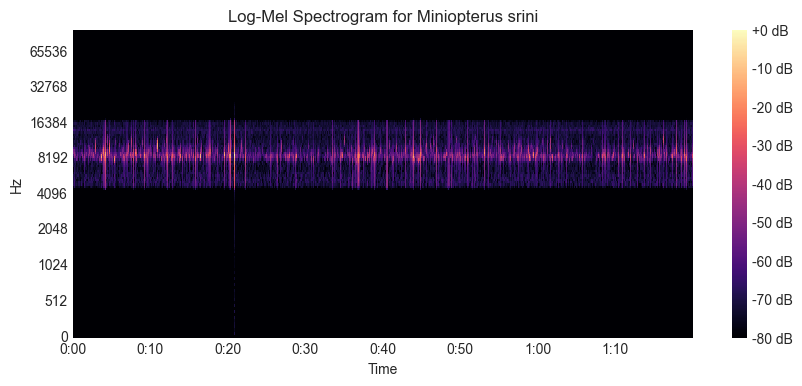

In [12]:
random_species = random.sample(list(species_counts.keys()), 2)
print("\nSpectral Feature Analysis for two random species:")
for sp in random_species:
    species_path = os.path.join(parent_folder, sp)
    files = get_all_audio_files(species_path)
    if files:
        sample_file = random.choice(files)
        waveform = load_audio(sample_file)
        if waveform is None:
            continue
        spec = waveform_to_logmel(waveform)
        centroid = compute_spectral_centroid(waveform)
        rolloff = compute_spectral_rolloff(waveform)
        print(f"Species: {sp}")
        print(f"  Sample file: {sample_file}")
        print(f"  Mean Spectral Centroid: {centroid:.2f} Hz")
        print(f"  Mean Spectral Rolloff: {rolloff:.2f} Hz")
        plt.figure(figsize=(10,4))
        librosa.display.specshow(spec, sr=192000, hop_length=512, x_axis='time', y_axis='mel')
        plt.title(f"Log-Mel Spectrogram for {sp}")
        plt.colorbar(format='%+2.0f dB')
        plt.show()
    else:
        print(f"No files found for species: {sp}")


Pickle loading failed for Cleaned Bat Echolocation calls of South India\Rhinolophus indorouxii\Castle Rock Water Tunnel-Bat Calls-21-Apr-2023\20230421_101320_1_20230421101335.pkf: invalid load key, 'k'.

For the most recorded species (Rhinolophus indorouxii):
  Sample file: Cleaned Bat Echolocation calls of South India\Rhinolophus indorouxii\Castle Rock Water Tunnel-Bat Calls-21-Apr-2023\20230421_101320_1_20230421101335.pkf
  Log-Mel Spectrogram min value: -80.00, max value: 0.00


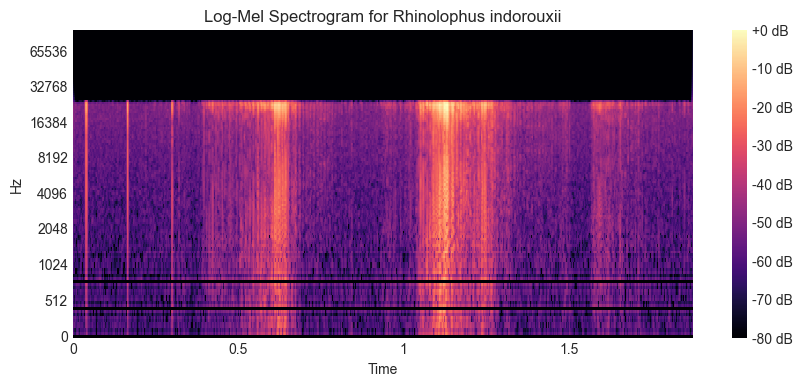


For the least recorded species (Hipposideros hyphophyllus):
  Sample file: Cleaned Bat Echolocation calls of South India\Hipposideros hyphophyllus\20240816_194942_4_20240816194942.wav
  Log-Mel Spectrogram min value: -80.00, max value: 0.00


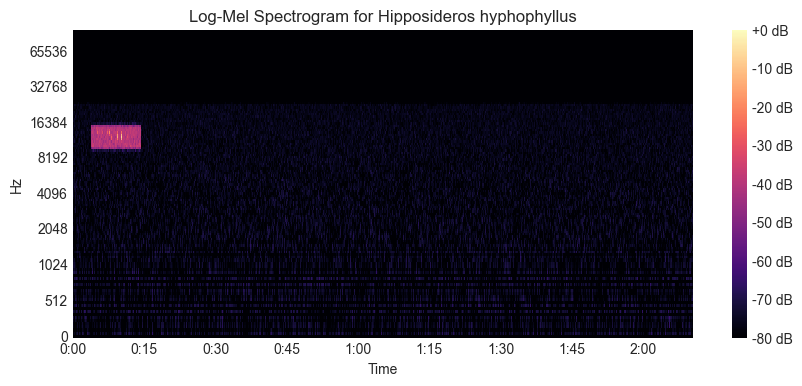

In [13]:
if top5:
    most_recorded_species = top5[0][0]
    most_files = get_all_audio_files(os.path.join(parent_folder, most_recorded_species))
    sample_most = random.choice(most_files)
    waveform_most = load_audio(sample_most)
    spec_most = waveform_to_logmel(waveform_most)
    print(f"\nFor the most recorded species ({most_recorded_species}):")
    print(f"  Sample file: {sample_most}")
    print(f"  Log-Mel Spectrogram min value: {np.min(spec_most):.2f}, max value: {np.max(spec_most):.2f}")
    plt.figure(figsize=(10,4))
    librosa.display.specshow(spec_most, sr=192000, hop_length=512, x_axis='time', y_axis='mel')
    plt.title(f"Log-Mel Spectrogram for {most_recorded_species}")
    plt.colorbar(format='%+2.0f dB')
    plt.show()

if least5:
    least_recorded_species = least5[0][0]
    least_files = get_all_audio_files(os.path.join(parent_folder, least_recorded_species))
    sample_least = random.choice(least_files)
    waveform_least = load_audio(sample_least)
    spec_least = waveform_to_logmel(waveform_least)
    print(f"\nFor the least recorded species ({least_recorded_species}):")
    print(f"  Sample file: {sample_least}")
    print(f"  Log-Mel Spectrogram min value: {np.min(spec_least):.2f}, max value: {np.max(spec_least):.2f}")
    plt.figure(figsize=(10,4))
    librosa.display.specshow(spec_least, sr=192000, hop_length=512, x_axis='time', y_axis='mel')
    plt.title(f"Log-Mel Spectrogram for {least_recorded_species}")
    plt.colorbar(format='%+2.0f dB')
    plt.show()


Using PKF file: Cleaned Bat Echolocation calls of South India/Pipistrellus ceylonicus\Avani-Ganji Gunte- Oct 2021\20211015_125509_20211015125509.pkf
Pickle loading failed for Cleaned Bat Echolocation calls of South India/Pipistrellus ceylonicus\Avani-Ganji Gunte- Oct 2021\20211015_125509_20211015125509.pkf: invalid load key, 'k'.


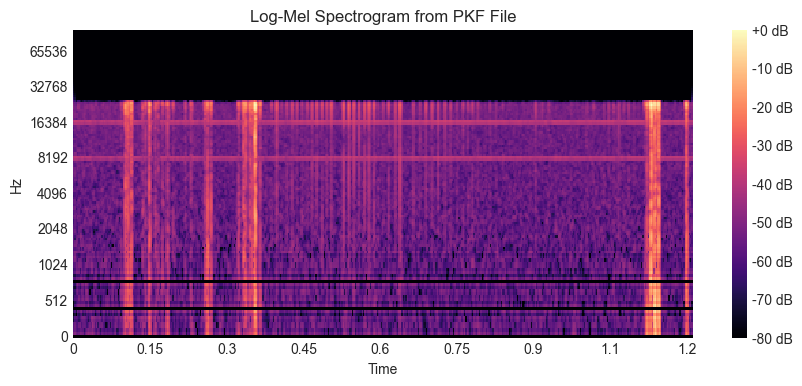

In [16]:
import os, glob, pickle, torchaudio, numpy as np, librosa, librosa.display, matplotlib.pyplot as plt

folder_1 = "Cleaned Bat Echolocation calls of South India/Pipistrellus ceylonicus"
pkf_files = glob.glob(os.path.join(folder_1, "**/*.pkf"), recursive=True)
if pkf_files:
    sample_pkf = pkf_files[0]
    print("Using PKF file:", sample_pkf)
    def load_audio(filepath, sr=192000):
        ext = os.path.splitext(filepath)[1].lower()
        if ext == ".pkf":
            try:
                with open(filepath, "rb") as f:
                    waveform = pickle.load(f)
                waveform = np.array(waveform, dtype=np.float32)
            except Exception as e:
                print(f"Pickle loading failed for {filepath}: {e}")
                with open(filepath, "rb") as f:
                    _ = f.read(20)
                    raw_data = f.read()
                waveform = np.frombuffer(raw_data, dtype=np.float32)
        return librosa.resample(waveform, orig_sr=48000, target_sr=sr)
    def waveform_to_logmel(waveform, sr=192000, n_mels=128, n_fft=2048, hop_length=512):
        S = librosa.feature.melspectrogram(y=waveform, sr=sr, n_fft=n_fft,
                                           hop_length=hop_length, n_mels=n_mels)
        return librosa.power_to_db(S, ref=np.max)
    waveform_pkf = load_audio(sample_pkf)
    if waveform_pkf is not None and waveform_pkf.size > 0:
        spec_pkf = waveform_to_logmel(waveform_pkf)
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(spec_pkf, sr=192000, hop_length=512, x_axis='time', y_axis='mel')
        plt.title("Log-Mel Spectrogram from PKF File")
        plt.colorbar(format='%+2.0f dB')
        plt.show()
    else:
        print("Skipping PKF file due to loading error.")
else:
    print("No PKF files found in", folder_1)


Total audio files found: 5808
Pickle loading failed for Cleaned Bat Echolocation calls of South India\Hipposideros fulvus\Anekal 01 Nov 2020\20201101_114716_2_20201101114716.pkf: invalid load key, 'k'.
Pickle loading failed for Cleaned Bat Echolocation calls of South India\Hipposideros fulvus\Anekal 01 Nov 2020\20201101_114828_2_20201101114828.pkf: invalid load key, 'k'.
Pickle loading failed for Cleaned Bat Echolocation calls of South India\Hipposideros fulvus\Belgaum Dec 2019\BCIT_N_20110101_175454_20110101175454.pkf: invalid load key, 'k'.
Pickle loading failed for Cleaned Bat Echolocation calls of South India\Hipposideros fulvus\Belgaum Dec 2019\BCIT_N_20191227_204554_20191227204554.pkf: invalid load key, 'k'.
Pickle loading failed for Cleaned Bat Echolocation calls of South India\Hipposideros fulvus\Belgaum-Dec 2019\20191225_104048_20191225104048.pkf: invalid load key, 'k'.
Pickle loading failed for Cleaned Bat Echolocation calls of South India\Hipposideros fulvus\Castle Rock Ivol

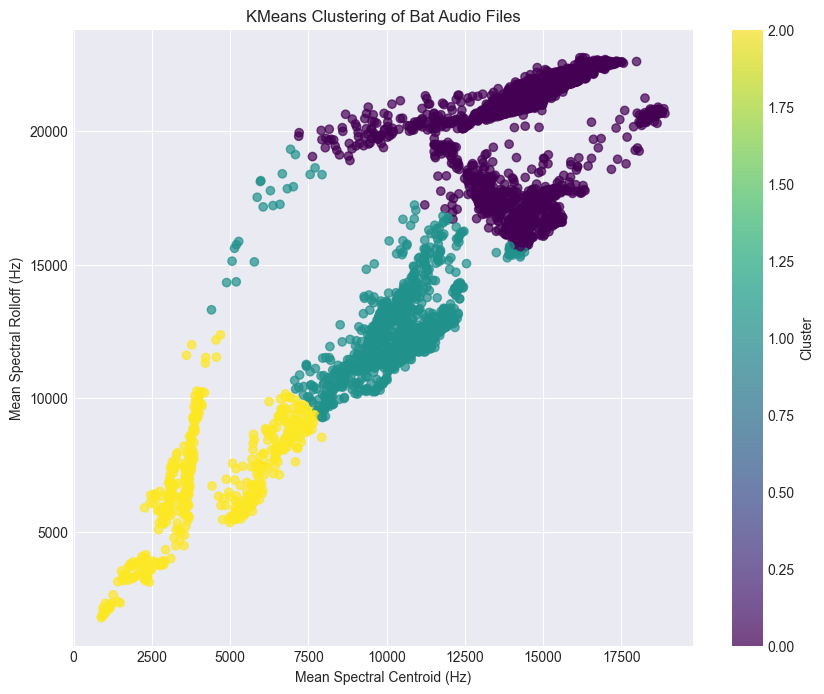

Clustered Sample (first 10 entries):
      Centroid       Rolloff  Cluster  \
0  6928.617583  19319.362500        1   
1  7202.983357  19939.898750        0   
2  7188.996032  19807.463750        0   
3  5979.306974  18143.295270        1   
4  5861.772797  17520.400000        1   
5  5272.202678  15866.666667        1   
6  5961.901288  18111.347591        1   
7  4546.234613  12177.654167        2   
8  3522.358371   7434.472629        2   
9  4885.531838  14325.899133        1   

                                                File  
0  Cleaned Bat Echolocation calls of South India\...  
1  Cleaned Bat Echolocation calls of South India\...  
2  Cleaned Bat Echolocation calls of South India\...  
3  Cleaned Bat Echolocation calls of South India\...  
4  Cleaned Bat Echolocation calls of South India\...  
5  Cleaned Bat Echolocation calls of South India\...  
6  Cleaned Bat Echolocation calls of South India\...  
7  Cleaned Bat Echolocation calls of South India\...  
8  Cleaned Bat E

In [17]:
import os
import glob
import pickle
import torchaudio
import numpy as np
import librosa
import matplotlib.pyplot as plt
import random
import pandas as pd
from sklearn.cluster import KMeans
import seaborn as sns

def get_all_audio_files(folder):
    """Recursively traverse folder to collect all .wav and .pkf file paths."""
    audio_files = []
    for root, dirs, files in os.walk(folder):
        for file in files:
            if file.lower().endswith(('.wav', '.pkf')):
                audio_files.append(os.path.join(root, file))
    return audio_files

def load_audio(filepath, sr=192000):
    """Load audio from a .wav or .pkf file; if PKF, try pickle then fallback."""
    ext = os.path.splitext(filepath)[1].lower()
    if ext == ".wav":
        try:
            waveform, _ = torchaudio.load(filepath)
            waveform = waveform.numpy()[0]  # Single-channel assumed
        except Exception as e:
            print(f"Error loading WAV file {filepath}: {e}")
            return None
    elif ext == ".pkf":
        try:
            with open(filepath, "rb") as f:
                waveform = pickle.load(f)
            waveform = np.array(waveform, dtype=np.float32)
        except Exception as e:
            print(f"Pickle loading failed for {filepath}: {e}")
            try:
                with open(filepath, "rb") as f:
                    _ = f.read(20)  # Skip header bytes
                    raw_data = f.read()
                waveform = np.frombuffer(raw_data, dtype=np.float32)
            except Exception as e2:
                print(f"Fallback loading failed for {filepath}: {e2}")
                return None
    else:
        print(f"Unsupported file type: {filepath}")
        return None
    try:
        waveform = librosa.resample(waveform, orig_sr=48000, target_sr=sr)
    except Exception as e:
        print(f"Error resampling {filepath}: {e}")
        return None
    return waveform

def compute_spectral_centroid(waveform, sr=192000):
    centroid = librosa.feature.spectral_centroid(y=waveform, sr=sr)
    return np.mean(centroid)

def compute_spectral_rolloff(waveform, sr=192000):
    rolloff = librosa.feature.spectral_rolloff(y=waveform, sr=sr)
    return np.mean(rolloff)

# Define the parent folder (containing 29 species folders, with wav/pkf files possibly in subfolders)
parent_folder = "Cleaned Bat Echolocation calls of South India"
all_files = get_all_audio_files(parent_folder)
print(f"Total audio files found: {len(all_files)}")

# Process each file to compute two features: mean spectral centroid and mean spectral rolloff.
features = []
file_paths = []  # to store corresponding file paths
for f in all_files:
    waveform = load_audio(f)
    if waveform is None:
        continue
    centroid = compute_spectral_centroid(waveform)
    rolloff = compute_spectral_rolloff(waveform)
    features.append([centroid, rolloff])
    file_paths.append(f)
features = np.array(features)
print(f"Computed features for {features.shape[0]} files.")

# Apply KMeans clustering (using k=3 clusters as an example)
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(features)

# Plot a scatter plot of features colored by cluster assignment.
plt.figure(figsize=(10,8))
scatter = plt.scatter(features[:,0], features[:,1], c=clusters, cmap='viridis', alpha=0.7)
plt.xlabel("Mean Spectral Centroid (Hz)")
plt.ylabel("Mean Spectral Rolloff (Hz)")
plt.title("KMeans Clustering of Bat Audio Files")
plt.colorbar(scatter, label="Cluster")
plt.show()

# Create a DataFrame to show a snippet of file clustering information.
df_cluster = pd.DataFrame(features, columns=["Centroid", "Rolloff"])
df_cluster["Cluster"] = clusters
df_cluster["File"] = file_paths
print("Clustered Sample (first 10 entries):")
print(df_cluster.head(10))
